In [1]:
# Basic Libraries

import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

In [2]:
import tensorflow.keras.backend as K
import tensorflow as tf

In [3]:
# Libraries for Classification and building Models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [4]:
# Project Specific Libraries

import os
import librosa
import librosa.display
import glob 
import skimage

/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [5]:
#para melhor gestão memória GPU por parte do tensorflow

def set_keras_backend(backend):
    print("A acertar o backend e libertar memória da grafica")
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        importlib.reload(K)
        assert K.backend() == backend
    if backend == "tensorflow":
        # Allow memory growth for the GPU
        physical_devices = tf.config.experimental.list_physical_devices('GPU')
        print(physical_devices)
        tf.config.experimental.set_memory_growth(physical_devices[0], True)


def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

set_keras_backend("tensorflow")

A acertar o backend e libertar memória da grafica
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
df = pd.read_csv("../../../datasets/UrbanSound8K/metadata/UrbanSound8K.csv")

'''We will extract classes from this metadata.'''

df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


### Data distribution

In [7]:
df['class'].value_counts()

drilling            1000
jackhammer          1000
engine_idling       1000
dog_bark            1000
air_conditioner     1000
children_playing    1000
street_music        1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

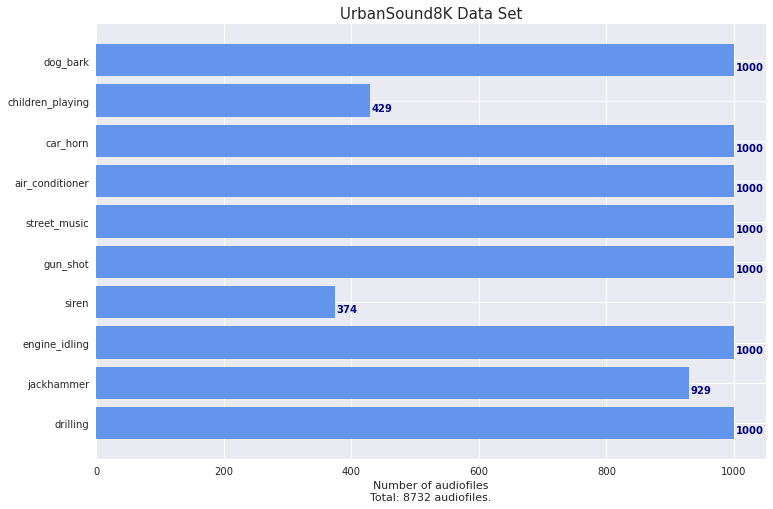

<Figure size 576x396 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import numpy as np

plt.style.use("seaborn")

#  data
def get_data_distribution():
    labels = df['class'].unique()
    num_labels_data = df.groupby('class').size()
    num_all_data = df['class'].count() 
    
    return labels, num_labels_data, num_all_data

labels, num_labels_data, num_all_data = get_data_distribution()

# plot
fig, ax = plt.subplots(figsize=(12, 8))

ax.barh(labels, num_labels_data, align='center', color='cornflowerblue', ecolor='black')
ax.set_yticks(labels)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel(f'Number of audiofiles\nTotal: {num_all_data} audiofiles.')
ax.set_title('UrbanSound8K Data Set', fontsize=15)
for i, v in enumerate(num_labels_data):
    ax.text(v + 3, i + .25, str(v), color="navy", fontweight='bold')

plt.show()
plt.savefig("data_distribution/data_distribution.png", bbox_inches='tight', 
            pad_inches=0.2, transparent=True)

#### Let's see on waveforms and spectogramms of audio files

In [9]:
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

In [18]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


def plot_wave_and_specgram(title, fn, data_type="waveform", 
                           columns=2, rows=16):
    
    fig = plt.figure(figsize=(16, 10))

    arr = np.array(df["slice_file_name"])
    fold = np.array(df["fold"])
    cla = np.array(df["class"])


    inds = np.random.randint(low=1, high=32, size=len(cla))
    for i, (label, ind) in enumerate(zip(labels, inds)):
        
        # data
        wave_path ='../../../datasets/UrbanSound8K/audio/fold' + str(fold[i]) + '/' + arr[i]
        # if readme.md, than continue
        if "".join(list(wave_path)[-4:]) != ".wav":
            continue

        samples, sample_rate = librosa.load(wave_path, sr=None)
       
        # plot
        ax = fig.add_subplot(rows, columns, i+1)
        if data_type == "waveform":
            colors = random.choices(list(mcolors.CSS4_COLORS.keys()),
                                k=len(labels))
            plt.plot(samples, label=label, color=colors[i]);
            plt.legend();
        elif data_type == "specgram":
            freqs, times, spectrogram = log_specgram(samples, sample_rate)
            ax.set_title(label);
            ax.imshow(spectrogram.T, aspect='auto',
                   extent=[times.min(), times.max(), freqs.min(), freqs.max()])
            plt.axis("off")
    
    plt.suptitle(title, 
                 fontsize=15, 
                 fontweight='bold')
    
    plt.savefig(fn, bbox_inches='tight', 
                    pad_inches=0.2, transparent=True)

    return plt.show()

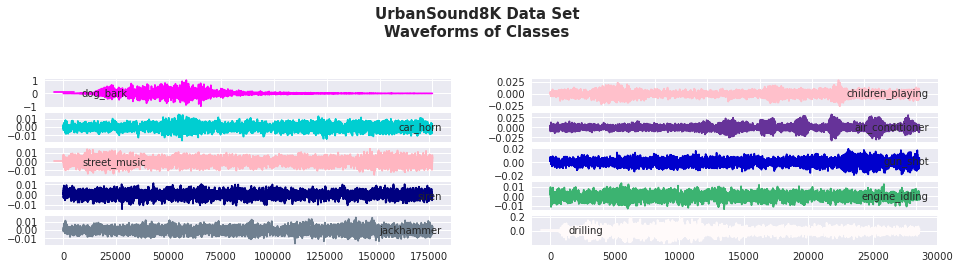

In [19]:
plot_wave_and_specgram(title='UrbanSound8K Data Set\nWaveforms of Classes',
                       fn="data_distribution/waves_of_classes.png",
                       data_type="waveform")

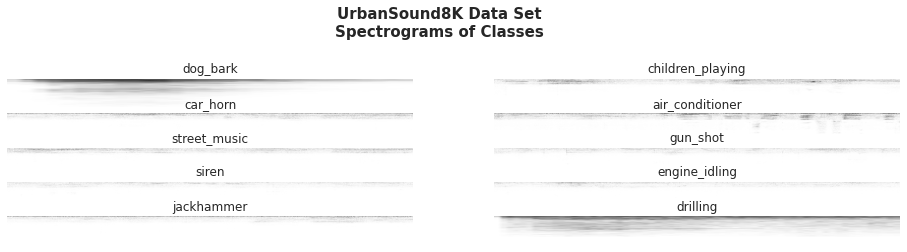

In [20]:
plot_wave_and_specgram(title='UrbanSound8K Data Set\nSpectrograms of Classes',
                       fn="data_distribution/specgram_of_classes.png",
                       data_type="specgram")